# Celebrities face recognition and emotion detection

## Necessary imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
import cv2
from multiprocessing import Pool, cpu_count

## Global path variables

In [2]:
base_url = '/kaggle/input/celeba-dataset/CelebA'
images_base_url = os.path.join(base_url, 'Img', 'img_align_celeba')
anno_base_url = os.path.join(base_url, 'Anno')
eval_base_url = os.path.join(base_url, 'Eval')
output_base_url = '/kaggle/working'
images_output_dir = os.path.join(output_base_url, 'images')
blurry_images_output_dir = os.path.join(output_base_url, 'blurry_images')
aligned_images_dir = os.path.join(output_base_url, 'aligned_images')

In [3]:
# List of all image files
image_files = os.listdir(images_base_url)

In [4]:
# Create the output directories if they don't exist
os.makedirs(images_output_dir, exist_ok=True)
os.makedirs(blurry_images_output_dir, exist_ok=True)
os.makedirs(aligned_images_dir, exist_ok=True)

In [5]:
identity = pd.read_csv(f'{anno_base_url}/identity_CelebA.txt', sep=' ', header=None, names=["image_id", "celebrity_id"])
identity.head()

,image_id,celebrity_id
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295


In [6]:
attributes = pd.read_csv(f'{anno_base_url}/list_attr_celeba.txt', sep='\s+', header=1)

# Reset index to make sure the image IDs are a column
attributes.reset_index(inplace=True)

# Rename columns for better readability
attributes.rename(columns={'index': 'image_id'}, inplace=True)

# Display the first few rows to verify
attributes.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [7]:
bounding_boxes = pd.read_csv(f'{anno_base_url}/list_bbox_celeba.txt', sep='\s+', header=1)
bounding_boxes.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


In [8]:
landmarks = pd.read_csv(f'{anno_base_url}/list_landmarks_align_celeba.txt', sep='\s+', header=1)

# Reset index to make sure the image IDs are a column
landmarks.reset_index(inplace=True)

# Rename columns for better readability
landmarks.rename(columns={'index': 'image_id'}, inplace=True)

landmarks.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [9]:
partitions = pd.read_csv(f'{eval_base_url}/list_eval_partition.txt', sep=' ', header=None, names=["image_id", "partition"])
partitions.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [10]:
images = attributes['image_id']
images.head()

0    000001.jpg
1    000002.jpg
2    000003.jpg
3    000004.jpg
4    000005.jpg
Name: image_id, dtype: object

In [11]:
first_image = cv2.imread(f'{images_base_url}/{images[0]}')
first_image.shape

(218, 178, 3)

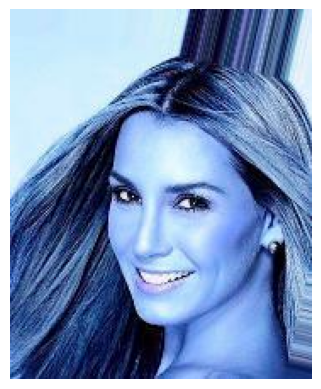

In [12]:
plt.imshow(first_image)
plt.axis('off')
plt.show()

In [13]:
# Function to check a single image dimension
def check_image(image_file):
    expected_size = (178, 218)
    image_path = os.path.join(images_base_url, image_file)
    try:
        with Image.open(image_path) as img:
            if img.size != expected_size:
                return (image_file, img.size)
    except Exception as e:
        return (image_file, str(e))
    return None

# Function to check dimensions of all images using multiprocessing
def verify_all_image_dimensions_parallel(images_base_url, num_workers=4):
    with Pool(num_workers) as pool:
        mismatched_images = pool.map(check_image, image_files)
    
    # Filter out None results
    mismatched_images = [img for img in mismatched_images if img is not None]
    
    return mismatched_images

# Check the dimensions of all images using multiprocessing
mismatched_images = verify_all_image_dimensions_parallel(images_base_url, num_workers=8)

if not mismatched_images:
    print("All images have the expected size of 178x218.")
else:
    print("Found images with mismatched dimensions:", mismatched_images)
    print(f"Total mismatched images: {len(mismatched_images)}")

All images have the expected size of 178x218.


In [14]:
# Function to detect blurry images
def is_blurry(image_path, threshold=100):
    img = cv2.imread(image_path)
    if img is None:
        return False  # Skip if image cannot be read
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur_score = cv2.Laplacian(gray, cv2.CV_64F).var()
    return blur_score < threshold

# Function to process images in parallel
def process_image(image_file):
    image_path = os.path.join(images_base_url, image_file)
    if is_blurry(image_path):
        return image_file
    return None

# Use multiprocessing to parallelize blur detection
def detect_blurry_images(num_workers=4):
    with Pool(num_workers) as pool:
        blurry_images = pool.map(process_image, image_files)
    
    # Filter out None results
    blurry_images = [img for img in blurry_images if img is not None]
    
    return blurry_images

# Detect blurry images using multiprocessing
blurry_images = detect_blurry_images(num_workers=8)

len(blurry_images)

7771

In [15]:
blurry_images[:20]

['178961.jpg',
 '127474.jpg',
 '128808.jpg',
 '031392.jpg',
 '162415.jpg',
 '129747.jpg',
 '033754.jpg',
 '198878.jpg',
 '178949.jpg',
 '044239.jpg',
 '099829.jpg',
 '136502.jpg',
 '189829.jpg',
 '110294.jpg',
 '200207.jpg',
 '046617.jpg',
 '130777.jpg',
 '191387.jpg',
 '157636.jpg',
 '008764.jpg']

In [16]:
# List of all blurry images
blurry_images_set = set(blurry_images)  # Convert to set for faster lookups

# Function to copy images based on whether they are blurry or not
def copy_image(image_file):
    src_path = os.path.join(images_base_url, image_file)
    if image_file in blurry_images_set:
        dst_path = os.path.join(blurry_images_output_dir, image_file)
    else:
        dst_path = os.path.join(images_output_dir, image_file)
    shutil.copy2(src_path, dst_path)

# Use multiprocessing to copy images
with Pool(processes=cpu_count()) as pool:
    pool.map(copy_image, image_files)

# Verify that the images have been copied correctly
remaining_images = os.listdir(images_output_dir)
copied_blurry_images = os.listdir(blurry_images_output_dir)

len(remaining_images), len(copied_blurry_images)

(194828, 7771)

In [17]:
# Function to detect noise in an image based on Laplacian variance
def detect_noise(image_file, threshold=100):
    try:
        image_path = os.path.join(images_output_dir, image_file)
        # Read the image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        
        # Calculate the Laplacian of the image
        laplacian = cv2.Laplacian(img, cv2.CV_64F).var()
        
        # Determine if the image is noisy based on the Laplacian variance
        if laplacian < threshold:
            return image_file
        else:
            return None
    except Exception as e:
        return None

# Threshold for detecting noise (adjust as needed)
noise_threshold = 100

# Function to process and detect noisy images in parallel
def process_images(image_files):
    with Pool(processes=cpu_count()) as pool:
        results = pool.starmap(detect_noise, [(image_file, noise_threshold) for image_file in image_files])
    return [image_file for image_file in results if image_file is not None]

# List of all image files in the sampled images directory
image_files = os.listdir(images_output_dir)

# Detect noisy images using multiprocessing
noisy_images = process_images(image_files)

len(noisy_images), len(image_files) - len(noisy_images)

(0, 194828)

In [18]:
# Select the reference image (image 38)
reference_image_id = '000038.jpg'
reference_landmarks_row = landmarks[landmarks['image_id'] == reference_image_id].iloc[0]

# Define the reference landmarks using the chosen reference image
reference_landmarks = {
    'lefteye': (reference_landmarks_row['lefteye_x'], reference_landmarks_row['lefteye_y']),
    'righteye': (reference_landmarks_row['righteye_x'], reference_landmarks_row['righteye_y']),
    'nose': (reference_landmarks_row['nose_x'], reference_landmarks_row['nose_y']),
    'leftmouth': (reference_landmarks_row['leftmouth_x'], reference_landmarks_row['leftmouth_y']),
    'rightmouth': (reference_landmarks_row['rightmouth_x'], reference_landmarks_row['rightmouth_y'])
}
reference_landmarks_points = np.array(list(reference_landmarks.values()), dtype=np.float32)

# Function to align faces based on landmarks
def align_face(image, landmarks, reference_landmarks, image_size=(178, 218)):
    src_points = np.array([
        (landmarks['lefteye_x'], landmarks['lefteye_y']),
        (landmarks['righteye_x'], landmarks['righteye_y']),
        (landmarks['nose_x'], landmarks['nose_y']),
        (landmarks['leftmouth_x'], landmarks['leftmouth_y']),
        (landmarks['rightmouth_x'], landmarks['rightmouth_y'])
    ], dtype=np.float32)
    transformation_matrix = cv2.estimateAffinePartial2D(src_points, reference_landmarks, method=cv2.LMEDS)[0]
    aligned_image = cv2.warpAffine(image, transformation_matrix, image_size)
    return aligned_image

# Function to align and save a single image
def process_and_save_image(image_file):
    image_path = os.path.join(images_output_dir, image_file)
    img = cv2.imread(image_path)
    if img is None:
        return
    landmarks_row = landmarks[landmarks['image_id'] == image_file].iloc[0]
    aligned_img = align_face(img, landmarks_row, reference_landmarks_points)
    aligned_image_path = os.path.join(aligned_images_dir, image_file)
    cv2.imwrite(aligned_image_path, aligned_img)

# Use multiprocessing to align images
with Pool(processes=cpu_count()) as pool:
    pool.map(process_and_save_image, remaining_images)

# Verify the number of aligned images
aligned_images = os.listdir(aligned_images_dir)
len(aligned_images)

194828

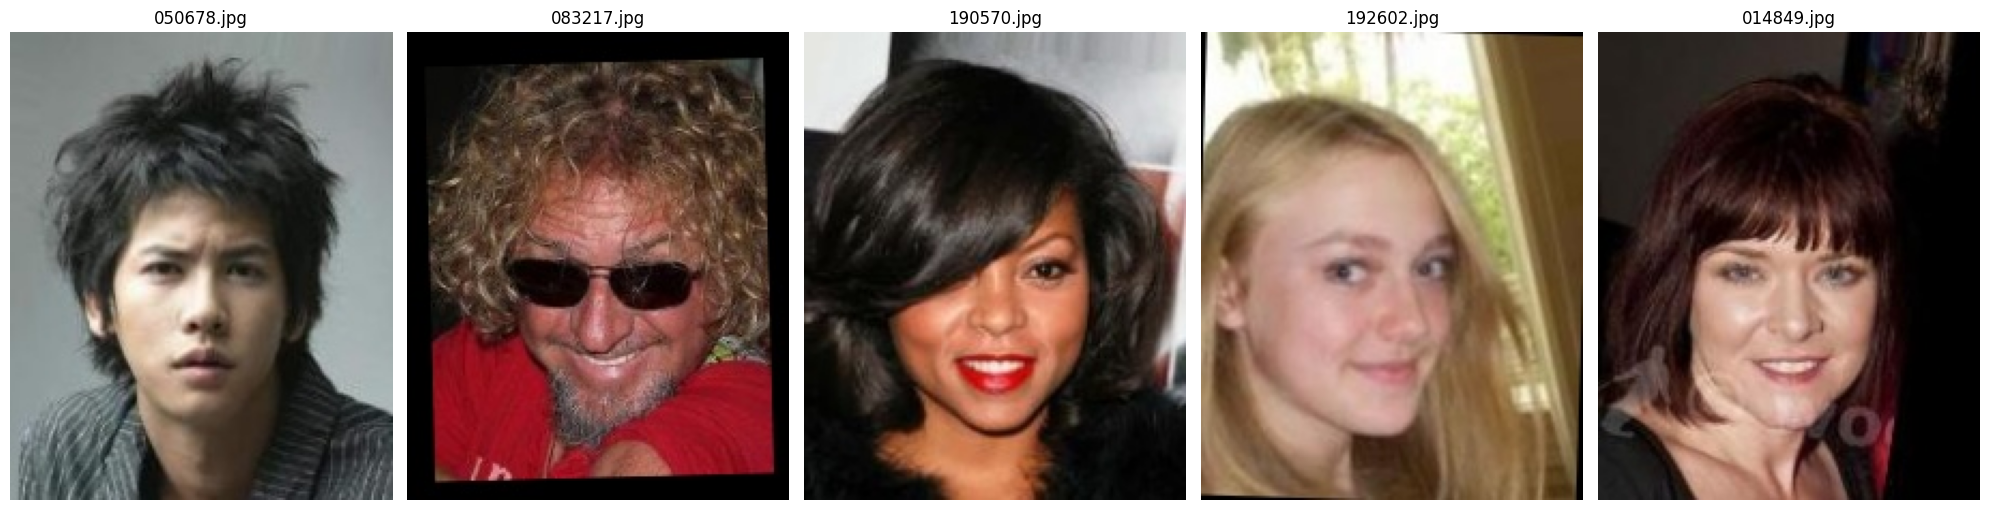

In [19]:
def display_images(images, num_images=5):
    image_files = images[:num_images]
    plt.figure(figsize=(20, 20))
    for i, image_file in enumerate(image_files):
        img = cv2.imread(os.path.join(aligned_images_dir, image_file))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(image_file)
    plt.tight_layout()
    plt.show()

# Display a few aligned images
display_images(aligned_images)